# Import cell

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.colors
import warnings
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
import os
import os.path
from matplotlib import cm
from scipy.signal import savgol_filter as sg
from scipy import interpolate

warnings.filterwarnings('ignore')

# Instructions

1. Set global parameters <br>
       a. global_n: An interger. How many components do you want to have? 
       c. save_path/add_in_save: Just where to save the figures etc.
2. Run all cells.

# Global Parameters

In [2]:
savebase = './'        #Where to save figures
global_n = 8           # Number of components in kmeans analysis
add_in_save = ''       # Add into the figure save name

path_to_data = './'   # Where is the data? If you keep it in a local folder named 'Raw_Data', there is no need to change this

# References

[1]  J. C. Agar, Y. Cao, B. Naul, S. Pandya, S. van der Walt, A. I. Luo, J. T. Maher, N. Balke, S. Jesse,S. V. Kalinin, R. K. Vasudevan,  and L. W. Martin, Advanced Materials 30, 1800701 (2018). <br>
[2]  J. C. Agar, B. Naul, S. Pandya, S. van der Walt, J. Maher, Y. Ren, L.-Q. Chen, S. V. Kalinin, R. K.Vasudevan, Y. Cao, J. S. Bloom,  and L. W. Martin, Nature Communications 10, 4809 (2019)

# Import and Clean Their Data

Import the data with scipy, which provides functions for loading matlab files

In [2]:
ls

'1) KMeans_Analysis.ipynb'  '4,5) DictLearn_CompAlphaStudy.ipynb'   loop_1.mat
'2) Error_Analysis.ipynb'    Data.mat


In [3]:
# imports the raw band excitation data
imported = {'data': io.matlab.loadmat('Data.mat'),
            'validation_data': io.matlab.loadmat('loop_1.mat')}

# extracts the important information from the raw data
raw = {'voltage': imported['data']['Voltagedata_mixed'],
       'piezoresponse': imported['data']['Loopdata_mixed'],
       'amplitude': imported['data']['OutA2_mixed'],
       'phase': imported['data']['OutPhi2_mixed'],
       'resonance': imported['data']['Outw2_mixed'],
       'quality_factor': imported['data']['OutQ2_mixed'],
       'val_piezoresponse': imported['validation_data']['piezo_1'],
       'val_resonance': imported['validation_data']['resonance_loop_1'],
       #'pr_1': imported['data']['OutA1_mixed']*np.sin(np.deg2rad(imported['data']['OutPhi1_mixed'])),
       'pr_1': imported['validation_data']['piezo_1'],
       'res_1': imported['data']['Outw1_mixed'],
       'amp_1': imported['data']['OutA1_mixed'],
       'ph_1': imported['data']['OutPhi1_mixed'],
       'q_1': imported['data']['OutQ1_mixed'],}

The cleaning functions and comments obtained from Agar et. al [1,2] <br>

In [4]:
def range_filter(data, ranges):
    """
    includes only data within a range of values as selected by the user.\n

    Parameters
    ----------
    data : numpy array
        array of loops
    ranges : array
        range of values to include

    Returns
    -------
    data : numpy array
        array of loops
    """
    # checks if data is 3 dimensions
    if data.ndim == 3:

        # manually removes values which are too high or too low
        for i in range(data.shape[0]):

            for j in range(data.shape[1]):

                # finds low and high values
                low = data[i, j] < min(ranges)
                high = data[i, j] > max(ranges)
                outliers = np.where(low + high)

                # removes found values and sets = nan
                data[i, j, outliers] = np.nan
    else:

        raise ValueError('Input data does not have a valid dimension')

    return data


def clean_interpolate(data, fit_type='spline'):
    """
    Function which removes bad data points

    Parameters
    ----------
    data : numpy, float
        data to clean
    fit_type : string  (optional)
        sets the type of fitting to use

    Returns
    -------
    data : numpy, float
        cleaned data
    """

    # sets all non finite values to nan
    data[~np.isfinite(data)] = np.nan
    # function to interpolate missing points
    data = interpolate_missing_points(data, fit_type)
    # reshapes data to a consistent size
    data = data.reshape(-1, data.shape[2])
    return data


def interpolate_missing_points(data, fit_type='spline'):
    """
    Interpolates bad pixels in piezoelectric hysteresis loops.\n
    The interpolation of missing points allows for machine learning operations

    Parameters
    ----------
    data : numpy array
        array of loops
    fit_type : string (optional)
        selection of type of function for interpolation

    Returns
    -------
    data_cleaned : numpy array
        array of loops
    """

    # reshapes the data such that it can run with different data sizes
    if data.ndim == 2:
        data = data.reshape(np.sqrt(data.shape[0]).astype(int),
                            np.sqrt(data.shape[0]).astype(int), -1)
        data = np.expand_dims(data, axis=3)
    elif data.ndim == 3:
        data = np.expand_dims(data, axis=3)

    # creates a vector of the size of the data
    point_values = np.linspace(0, 1, data.shape[2])

    # Loops around the x index
    for i in range(data.shape[0]):

        # Loops around the y index
        for j in range(data.shape[1]):

            # Loops around the number of cycles
            for k in range(data.shape[3]):

                if any(~np.isfinite(data[i, j, :, k])):

                    # selects the index where values are nan
                    ind = np.where(np.isnan(data[i, j, :, k]))

                    # if the first value is 0 copies the second value
                    if 0 in np.asarray(ind):
                        data[i, j, 0, k] = data[i, j, 1, k]

                    # selects the values that are not nan
                    true_ind = np.where(~np.isnan(data[i, j, :, k]))

                    # for a spline fit
                    if fit_type == 'spline':
                        # does spline interpolation
                        spline = interpolate.InterpolatedUnivariateSpline(point_values[true_ind],
                                                                          data[i, j, true_ind, k].squeeze())
                        data[i, j, ind, k] = spline(point_values[ind])

                    # for a linear fit
                    elif fit_type == 'linear':

                        # does linear interpolation
                        data[i, j, :, k] = np.interp(point_values,
                                                     point_values[true_ind],
                                                     data[i, j, true_ind, k].squeeze())

    return data.squeeze()


In [5]:
# These cleaning steps were also performed in [1,2]
range_filter(raw['resonance'], [1300, 1340])          # "Hard limit" replace resonance values outside the specified range with NaN     
range_filter(raw['val_resonance'], [1300, 1340])      # Same for the first cycle resonance
clean_interpolate(raw['resonance'],'linear').reshape(-1, raw['resonance'].shape[2])    #Interpolate those NaNs

array([[1316.56298484, 1316.85098085, 1316.4753691 , ..., 1317.9234046 ,
        1318.10937733, 1318.03857044],
       [1319.31182758, 1319.11098001, 1319.36025077, ..., 1320.27286958,
        1320.16729895, 1320.17534472],
       [1319.29792087, 1319.05178431, 1319.07999963, ..., 1319.37266502,
        1319.58981849, 1319.87632619],
       ...,
       [1327.44357597, 1327.31951814, 1327.33201154, ..., 1327.70510708,
        1327.78603897, 1327.80754424],
       [1327.17790234, 1327.34066654, 1327.21556803, ..., 1327.87324892,
        1327.72284503, 1327.75400904],
       [1326.7496446 , 1326.96006052, 1326.98423162, ..., 1327.18681378,
        1327.33968267, 1327.23022542]])

# Extract and Format 

Extract the data we are interested in (second cycle) and put into a format we are more familiar with.

In [6]:
# extract the second cycle data (amplitude, phase, resonance, and Q)
second_amp = np.reshape(raw['amplitude'],(3600,96))
second_ph = np.reshape(raw['phase'],(3600,96))
second_res = np.reshape(raw['resonance'],(3600,96))
second_q = np.reshape(raw['quality_factor'],(3600,96))

# Extract the provided "optimal rotation angle"
opt_ang = np.reshape(imported['data']['optrotang_mixed'],(3600))

# Resonstrcut the second cycle PR
second_ph = second_ph+np.mean(opt_ang)
second_pr = second_amp*np.cos(np.deg2rad(second_ph))

#Extract voltage data
v_cycle = imported['data']['VoltageDC_mixed'][:,0].squeeze()


In [7]:
# Replace any infinte values in the amplitude/phase curves with NaN. NaNs can be ignored when taking the mean, infs can't.
second_amp[~np.isfinite(second_amp)] = np.nan
second_ph[~np.isfinite(second_ph)] = np.nan

# Get the mean maps for plotting later
sA_mean = np.nanmean(second_amp, axis=1)
sP_mean = np.nanmean(second_ph, axis=1)
sR_mean = np.nanmean(second_res, axis=1)
sQ_mean = np.nanmean(second_q, axis=1)
sPR_mean = np.nanmean(second_pr, axis=1)


### Convert their data to a Pandas DataFrame

In [8]:
all_second = np.hstack([second_res,second_pr])   # Here we are mostly looking at the piezoresponse and resonance data
num_vars = 2    # That two variables

#-------------Generate all of the various labels to use in the data frame
times = 96
all_vals = np.repeat('Res', times)
for var in ['PR']:
    varlist = np.repeat(var, times)
    all_vals = np.hstack([all_vals,varlist])

xvals = np.hstack([v_cycle,v_cycle])
chirps = np.tile(np.arange(times),num_vars)
inout = np.tile(np.full(times, 0),num_vars)
plotgroup = np.tile(np.full(times, 0),num_vars)
arrays =[all_vals,chirps,inout,plotgroup,xvals]

cols = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Vars', 'ChirpNum','InOut','PlotGroup','xaxis'])
index = pd.Index(np.arange(3600).astype(int),name='Acq')
#---------------

# Create the dataframe
second_data = pd.DataFrame(all_second, columns=cols, index=index)

# Plot Code

In [9]:
def plot_map(ax, clusters, cmap, norm):
    im = ax.imshow(clusters, cmap=cmap, norm=norm, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    return im
    
def plot_comp(ax, i, centroids, cmap, kwargs_comps={}, kwargs_text={},labelpad=None, topPlot=False, conv=[6,0,4,5,3,1,7,2]):
    voltages = data[var].columns.get_level_values('xaxis')
    #ax.plot(voltages,std_mean[var][1]+std_mean[var][0]*(centroids[i]/1000), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    
    #plotdata = (centroids/np.mean(centroids)-1)*100
    plotdata = centroids - np.mean(centroids)
    #plotdata = centroids
    
    #if topPlot:
    #    ax.plot(voltages,((plotdata[i]+second_offsets[var])), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    #else:
    #    ax.plot(voltages,((plotdata[i]+second_offsets[var])), label="Cluster " + str(i), color=cmap(i), **kwargs_comps)
    
    j = conv[i]

    if topPlot:
        ax.plot(voltages,((plotdata[j])), label="Cluster " + str(i), color=cmap(j), **kwargs_comps)
    else:
        ax.plot(voltages,((plotdata[j])), label="Cluster " + str(i), color=cmap(j), **kwargs_comps)
    
    half_n = int(global_n/2)
    
    if i == half_n:
        if topPlot:
            ax.annotate('Voltage (V)',(-0.45,1.3),xycoords='axes fraction',**kwargs_text)
        else:
            ax.annotate('Voltage (V)',(-0.45,-0.35),xycoords='axes fraction',**kwargs_text)
        
    if topPlot:
        ax.xaxis.set_label_position("top")
        ax.xaxis.set_ticks_position("top")

    plt.xticks(**kwargs_text)
    
    if i != global_n-1:
        ax.set_yticks([])
    else:
        if not topPlot:
            #ax.set_ylabel('Deviation. (kHz)', **kwargs_text)
            #ax.annotate('Res. Deviation (kHz)', (1.5,0.4),xycoords='axes fraction', rotation='vertical', **kwargs_text)
            ax.set_ylabel(r'$\Delta \omega$ (kHz)', **kwargs_text)
        else:
            ax.set_ylabel(r'$\omega$ (kHz)', **kwargs_text)
        #    ax.set_ylabel('Resonance (kHz)', **kwargs_text)
        #    ax.annotate(str(int(np.mean(centroids)))+'+', (0.5,1.05),xycoords='axes fraction', rotation='horizontal', **kwargs_text)
            ax.set_yticklabels(['','-5',r'$\omega_0$','5'])
        ax.yaxis.set_label_position("right")
        #ax.set_yticklabels('')
        ax.yaxis.tick_right()
        plt.yticks(**kwargs_text)
        
    ax.set_xticks([-10,10])

def plot_all_kmeans(gs, clusters, centroids, kwargs_top_grid={'width_ratios': [0.235,1], 'height_ratios' : [1,0.05],'wspace' : 0.015},
                                          kwargs_comp_grid={'width_ratios': np.repeat(1,global_n), 'wspace' : 0},
                                          kwargs_text={},
                                          kwargs_large_text={},
                                          labelpad=None, topPlot=False, conv=[6,0,4,5,3,1,7,2]):
    
    fig = plt.gcf()
    
    #gs = fig.add_gridspec(1, 2, **kwargs_top_grid)
    top_level_gs = gs.subgridspec(2, 2, **kwargs_top_grid)
    gs_left = top_level_gs[0,1].subgridspec(1, global_n, **kwargs_comp_grid)
    
    ax = fig.add_subplot(top_level_gs[0])
    im = plot_map(ax, clusters, cmap, norm)
    
    if topPlot:
        ax.annotate('a.',(-0.22,0.9),xycoords='axes fraction',**kwargs_large_text)
    else:
        ax.annotate('c.',(-0.22,0.9),xycoords='axes fraction',**kwargs_large_text)
    
    ymin_list = []
    ymax_list = []
    ax_list = []
        
    for i in range(global_n):
        
        ax = fig.add_subplot(gs_left[i])
        plot_comp(ax, i, centroids, cmap, labelpad=labelpad, topPlot=topPlot, kwargs_text=kwargs_text, conv=conv)
        
        if topPlot:
            #ax.set_ylabel('')
            ax.set_xlabel('')
            #ax.set_xticklabels('')
        
        ymin, ymax = ax.get_ylim()
        ymin_list.append(ymin)
        ymax_list.append(ymax)
        ax_list.append(ax)
        #plt.ylim((1.315e6,1.331e6))
        #plt.title("Cluster" + str(i))
        #plt.legend()#bbox_to_anchor=(1.4,1))
    
    for ax in ax_list:
        yrange = np.abs(min(ymin_list)-max(ymax_list))
        incr_range = yrange*0.08    
        if topPlot:
            ax.set_ylim([min(ymin_list)-incr_range,max(ymax_list)+incr_range])
        else:
            ax.set_ylim([-2.5,2.5])
            #ax.set_ylim([min(ymin_list)-incr_range,max(ymax_list)+incr_range])
        
    #if not topPlot:
    #    ax = fig.add_subplot(top_level_gs[1,0])
    #    cb = plt.colorbar(im, cax=ax, orientation='horizontal',ticks=np.arange(global_n))
        #cb.set_label(label='Cluster',**kwargs_text)
    #    cb.ax.tick_params(labelsize=kwargs_text['fontsize'])

def plot_mean_maps(gs, data, kwargs_top_grid={'width_ratios': [1,1,1,1], 'height_ratios' : [1], 'hspace':0.02 },kwargs_large_text={}):
    
    fig = plt.gcf()
    
    top_level_gs = gs.subgridspec(1, 4, **kwargs_top_grid)
    
    sub_labels = ['b.','d','e','f']
    
    for i, var in enumerate(data):
        gs_map = top_level_gs[i].subgridspec(1, 2, width_ratios=[1,0.05],wspace=0.01)
        ax = fig.add_subplot(gs_map[0])
        cax = fig.add_subplot(gs_map[1])
                
        #if var is 'Amplitude (a.u.)':
        if i == 0:
            plot_data = data[var]*1e6
        #elif var is r'Phase ($^\circ$)':
        elif i == 1:
            plot_data = data[var] - np.min(data[var])
        #elif var is 'Q (a.u.)':
        elif i == 2:
            plot_data = data[var]
        #elif var is 'Resonance (kHz)':
        elif i == 3:
            plot_data = data[var]
        
        c_map_val = 'viridis'
        
        if i == 0:
            im = ax.imshow(np.reshape(plot_data,(60,60)), cmap=c_map_val, vmin=25,vmax=102)
        if i == 1:
            im = ax.imshow(np.reshape(plot_data,(60,60)), cmap=c_map_val)
        if i == 2:
            im = ax.imshow(np.reshape(plot_data,(60,60)), cmap=c_map_val)
        if i == 3:
            im = ax.imshow(np.reshape(plot_data,(60,60)), cmap=c_map_val, vmin=1309,vmax=1331)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0 :
            ax.annotate(sub_labels[i],(-0.205,0.9),xycoords='axes fraction',**kwargs_large_text)
        
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        ax.set_title(var,fontsize=9)
        cbar.ax.tick_params(labelsize=8)
        #cbar.ax.set_ylabel(var,fontsize=9)

        if i == 0:
        #    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
            cbar.ax.set_ylim([25,102])
            cbar.set_ticks([25,50,75,100])
            cbar.set_ticklabels([25,50,75,100])
            #cbar.set_ticks([30,50,70,90])
            #cbar.set_ticklabels([30,50,70,90])
        if i == 1:
            #cbar = plt.colorbar(im, cax=cax, orientation='', label=var)
            cbar.set_ticks([0,25,50,75,100,125])
            cbar.set_ticklabels([0,25,50,75,100,125])
        if i == 2:
            #cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
            cbar.set_ticks([175,200,225,250])
            cbar.set_ticklabels([175,200,225,250])
        if i == 3:
            #cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=var)
            #cbar.set_ticks([1310,1315,1320,1325,1330])
            #cbar.set_ticklabels([1310,1315,1320,1325,1330])
            #cbar.ax.set_ylim([1309,1331])
            cbar.set_ticks([1310,1315,1320,1325,1330])
            cbar.set_ticklabels([1310,1315,1320,1325,1330])



# Run our Analysis

#### K-means without Mean Removed

In [10]:
# Run kmeans
var = ['Res']         # Variable to run
data = second_data    # Data to run
voltages = v_cycle    # x-axis data, i.e. voltages

orig_shape = [60,60]
nclusters = global_n
voltages = data[var].columns.get_level_values('xaxis')

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data[var])
clus_wo_mean_removal = kmeans.labels_.reshape((orig_shape[0], orig_shape[1]))
cent_wo_mean_removal = kmeans.cluster_centers_

#### K-means with Mean Removed

In [11]:
# For each row of data (i.e. spatial point), remove the mean of the row
second_data['Res'] = second_data['Res'].apply(lambda x: x-x.mean(), axis=1)
second_data['PR'] = second_data['PR'].apply(lambda x: x-x.mean(), axis=1)

In [12]:
# Run kmeans
var = ['Res']         # Variable to run
data = second_data    # Data to run
voltages = v_cycle    # x-axis data, i.e. voltages

orig_shape = [60,60]
nclusters = global_n
voltages = data[var].columns.get_level_values('xaxis')

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data[var])
clus_mean_removal = kmeans.labels_.reshape((orig_shape[0], orig_shape[1]))
cent_mean_removal = kmeans.cluster_centers_

In [13]:
#make a nice color map
my_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink','tab:gray']
new_colors = np.asarray(['navy', 'cornflowerblue', 'mediumorchid', 'limegreen', 'cyan', 'gold', 'tomato','black'])
new_colors[[6,0,5,2,7,4,1,3]] = my_colors
my_colors = new_colors
    
cmap = matplotlib.colors.ListedColormap(my_colors)
boundaries = np.arange(len(my_colors)+1)-0.5
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

In [14]:
import matplotlib.gridspec as gridspec

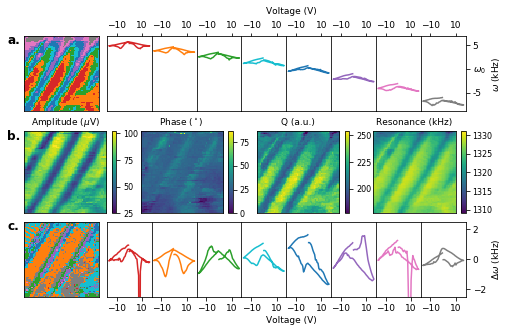

In [15]:
#Plot!!!
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(3, 1, height_ratios=[0.65,0.62,0.65], hspace=0.1)

plot_all_kmeans(gs[0], clus_wo_mean_removal, cent_wo_mean_removal, labelpad=6, kwargs_text={'fontsize' : 9}, topPlot=True, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold', 'color':'k'},conv=[6,0,5,2,7,4,1,3])
plot_all_kmeans(gs[2], clus_mean_removal, cent_mean_removal, labelpad=100, kwargs_text={'fontsize' : 9}, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold', 'color':'k'},conv=[6,0,5,2,7,4,1,3])

plot_mean_maps(gs[1], {r'Amplitude ($\mu$V)':sA_mean,r'Phase ($^\circ$)':sP_mean,'Q (a.u.)':sQ_mean,'Resonance (kHz)':sR_mean}, kwargs_large_text={'fontsize':12,'color':'k','fontweight':'bold'})

In [15]:
#Save!
fig.tight_layout()
fig.savefig(savebase+'kmeans_second'+'.eps', format='eps', dpi=500)
fig.savefig(savebase+'kmeans_second'+'.png', format='png', dpi=500)